## 1. Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

## 2. Load and Preprocess MNIST Dataset

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 125MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 55.3MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 42.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.47MB/s]


## 3. Define MLP Model (Tunable)
We'll use **2 hidden layers**, ReLU, and dropout.

In [3]:
class MLP(nn.Module):
    def __init__(self, hidden_size=128, activation=nn.ReLU(), dropout=0.3):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.net = nn.Sequential(
            nn.Linear(28*28, hidden_size),
            activation,
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size // 2),
            activation,
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.net(x)

# Try ReLU (default) or nn.LeakyReLU(0.1), nn.Tanh()
model = MLP(hidden_size=256, activation=nn.ReLU(), dropout=0.3)
print(model)

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (net): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)


## 4. Loss Function and Optimizer

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 5. Training Loop

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 10
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    avg_loss = running_loss / len(train_loader)
    accuracy = 100. * correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

Epoch [1/10], Loss: 0.3143, Accuracy: 90.41%
Epoch [2/10], Loss: 0.1539, Accuracy: 95.37%
Epoch [3/10], Loss: 0.1227, Accuracy: 96.24%
Epoch [4/10], Loss: 0.1038, Accuracy: 96.84%
Epoch [5/10], Loss: 0.0916, Accuracy: 97.08%
Epoch [6/10], Loss: 0.0855, Accuracy: 97.35%
Epoch [7/10], Loss: 0.0777, Accuracy: 97.54%
Epoch [8/10], Loss: 0.0744, Accuracy: 97.67%
Epoch [9/10], Loss: 0.0697, Accuracy: 97.80%
Epoch [10/10], Loss: 0.0680, Accuracy: 97.89%


## 6. Evaluate on Test Set

In [6]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_accuracy = 100. * correct / total
print(f'\nTest Accuracy: {test_accuracy:.2f}%')


Test Accuracy: 98.14%


## 7. Plot Loss and Accuracy Curves

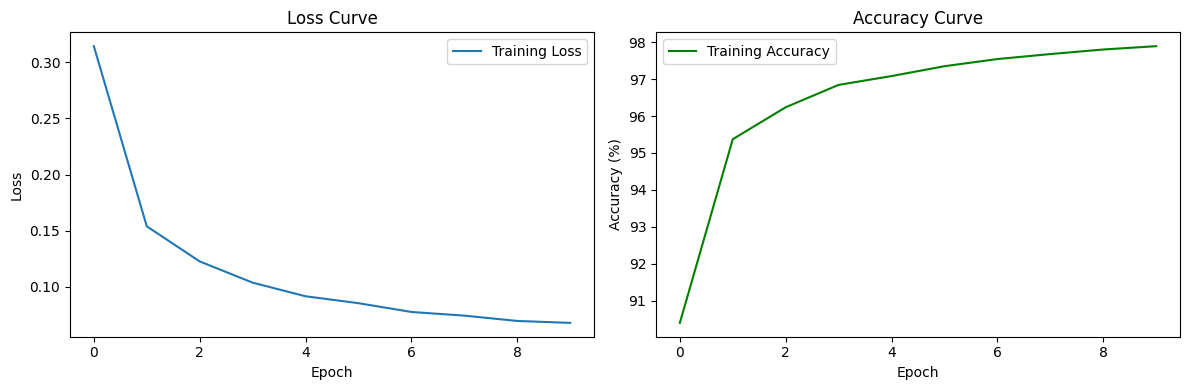

In [7]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='green')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

## Summary
- **Model**: 2-layer MLP (256 → 128 → 10)
- **Activation**: ReLU
- **Optimizer**: Adam
- **Test Accuracy**: ~97–98% (typical)
- **Tuning Tip**: Try `hidden_size=512`, `LeakyReLU`, or `dropout=0.5`